In [ ]:
save = True
if save:
    ! rm -r sample_data/
    ! mkdir -p scenes disk hyperbolas patterns complex model metrics results
pretrained = False

# Data

## Code

In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

In [ ]:
H = 100
W = H

trans_t = lambda t : np.array([
    [1,0,0],
    [0,1,-t],
    [0,0,1]
])

rot_theta = lambda th : np.array([
    [np.cos(th),-np.sin(th),0],
    [np.sin(th),np.cos(th),0],
    [0,0,1]
])

def pose_spherical(theta, radius, phi=0):
    c2w = rot_theta(phi/180*np.pi)
    c2w = trans_t(radius) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    return c2w

def xy2xyc(xy): return np.repeat(img2D[...,None] if len(img2D.shape)<3 else img2D,3,axis=-1)

def xy2ij(xy,H,W): return np.flip(xy*np.array([1,-1])+np.array([(W-1)//2,(H-1)//2]),axis=-1).astype(int)

def get_1st_pixel(img2D,ray):
    pixel = np.zeros((3,))
    H,W,_ = img2D.shape
    for i,j in xy2ij(ray,H,W):
        if (img2D[i,j]!=pixel).any(): return img2D[i,j]
    return pixel

def get_rays(W, focal, c2w):
    x = np.meshgrid(np.arange(W))[0]
    dirs = np.stack([(x-(W-1)/2)/focal, np.ones_like(x)],axis=-1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:2,:2],axis=-1)
    rays_o = np.broadcast_to(c2w[:2,-1],rays_d.shape)
    return rays_o, rays_d

def plot_rays(img2D, rays_o, rays):
    img2D = img2D.copy()
    H,W,_ = img2D.shape
    i, j = xy2ij(rays_o[0],H,W)
    img2D[i,j] = [1,1,1]
    for ray in rays:
        for i,j in xy2ij(ray,H,W):
            if True or 0==img2D[i,j].sum(): img2D[i,j] = [1,1,1]

    plt.figure(figsize=(8,9))
    plt.subplot2grid((9,1),(0,0),rowspan=8)
    plt.gca().set_facecolor('black')
    plt.imshow(img2D)
    plt.xticks([])
    plt.yticks([])
    H,W,_ = img2D.shape
    plt.xticks([])
    plt.yticks([])

def project_rays(img2D, rays_o, rays_d, near, far, N_samples,show=False):
    z_vals = np.linspace(near, far, N_samples)
    rays = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    if show: plot_rays(img2D,rays_o,rays)
    image1D = np.zeros((1,rays.shape[0],3))
    for j, ray in enumerate(rays): image1D[0,j] = get_1st_pixel(img2D,ray)
    return image1D

## Examples

### 2D Scenes

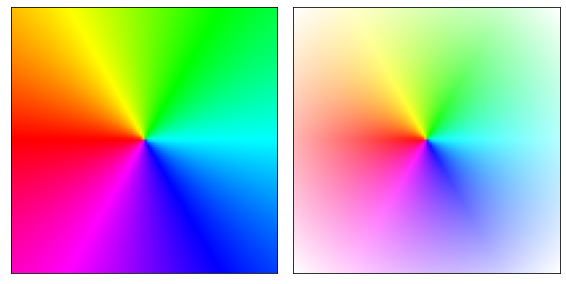

In [ ]:
img2D = np.zeros((H,W))
ii, jj = np.meshgrid(np.arange(H),np.arange(W),indexing='ij')
ii = ii-(H-1)/2
jj = jj-(W-1)/2
theta = np.arctan2(ii,jj)
hue = (theta+np.pi)/2/np.pi
color = hsv_to_rgb(np.stack((hue,np.ones_like(hue),np.ones_like(hue)),axis=-1))
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.xticks([])
plt.yticks([])
plt.imshow(color)
grad = (ii**2+jj**2)**0.5
grad = (grad.max()-grad)/grad.max()
color_grad = hsv_to_rgb(np.stack((hue,grad,np.ones_like(hue)),axis=-1))
plt.subplot(122)
plt.imshow(color_grad)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
if save: plt.savefig('scenes/colors')
plt.show()

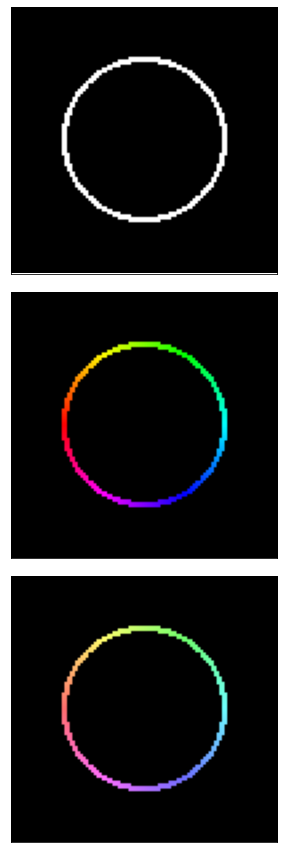

In [ ]:
img2D = np.zeros((H,W))
r = 30
w = 1
fn = lambda y,x: x**2+y**2
cond = lambda ii,jj,c: np.logical_and(-c**2<=fn(ii,jj),fn(ii,jj)<=c**2)
img2D[cond(ii,jj,w+r)] = 1
img2D[cond(ii,jj,w-r)] = 0
circle = xy2xyc(img2D)
plt.figure(figsize=(4,12))
plt.subplot(311)
plt.imshow(circle)
plt.xticks([])
plt.yticks([])
plt.subplot(312)
plt.imshow(circle*color)
plt.xticks([])
plt.yticks([])
plt.subplot(313)
plt.imshow(circle*color_grad)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
if save: plt.savefig('scenes/circles')
plt.show()

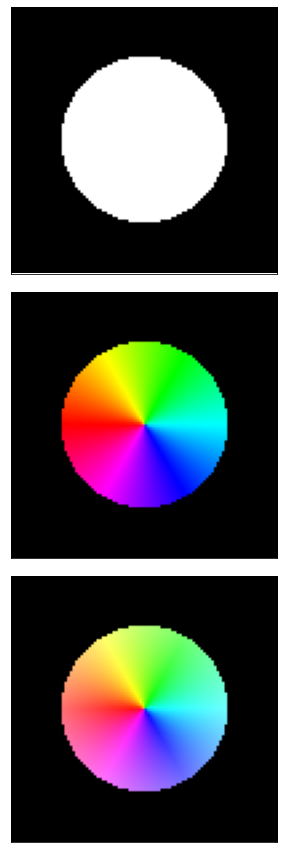

In [ ]:
img2D = np.zeros((H,W))
r = 30
w = 1
fn = lambda y,x: x**2+y**2
cond = lambda ii,jj,c: np.logical_and(-c**2<=fn(ii,jj),fn(ii,jj)<=c**2)
img2D[cond(ii,jj,w+r)] = 1
disk = xy2xyc(img2D)
plt.figure(figsize=(4,12))
plt.subplot(311)
plt.xticks([])
plt.yticks([])
plt.imshow(disk)
plt.subplot(312)
plt.xticks([])
plt.yticks([])
plt.imshow(disk*color)
plt.subplot(313)
plt.imshow(disk*color_grad)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
if save: plt.savefig('scenes/disks')
plt.show()

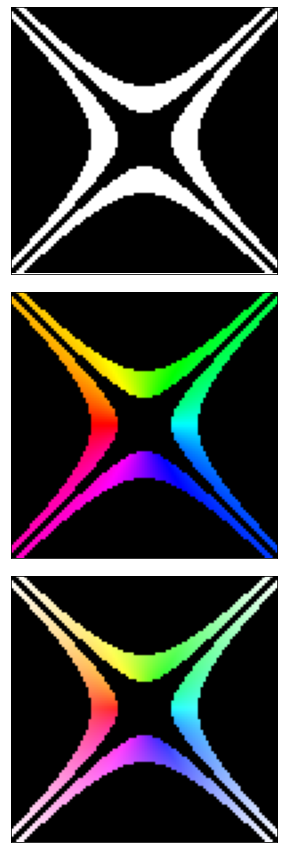

In [ ]:
img2D = np.zeros((H,W))
fn = lambda y,x: y**2-x**2
cond = lambda ii,jj,c: np.logical_and(-c**2<=fn(ii,jj),fn(ii,jj)<=c**2)
img2D[cond(ii,jj,20)] = 1
img2D[cond(ii,jj,10)] = 0
hyperbolas = xy2xyc(img2D)
plt.figure(figsize=(4,12))
plt.subplot(311)
plt.xticks([])
plt.yticks([])
plt.imshow(hyperbolas)
plt.subplot(312)
plt.imshow(hyperbolas*color)
plt.xticks([])
plt.yticks([])
plt.subplot(313)
plt.xticks([])
plt.yticks([])
plt.imshow(hyperbolas*color_grad)
plt.tight_layout()
if save: plt.savefig('scenes/hyperbolas')
plt.show()

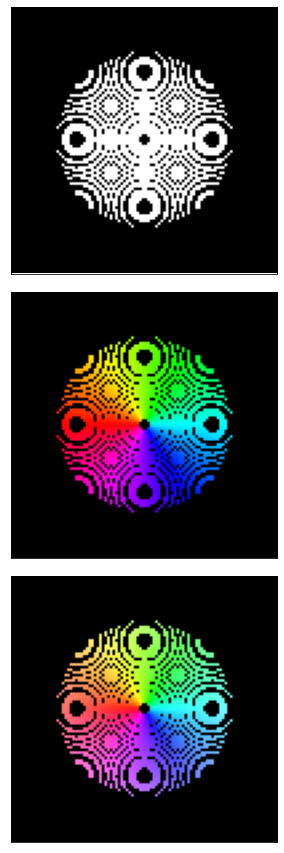

In [ ]:
img2D = np.zeros((H,W))
sigma = 20
fn = lambda y,x: np.exp(-(x**2+y**2)/2/sigma**2)*np.sin(2*np.pi/100*(x**2+y**2))
cond = lambda ii,jj,c: np.logical_and(-c<=fn(ii,jj),fn(ii,jj)<=c)
img2D[cond(ii,jj,0.25)] = -1
img2D += 1
pattern = xy2xyc(img2D)
plt.figure(figsize=(4,12))
plt.subplot(311)
plt.imshow(pattern)
plt.xticks([])
plt.yticks([])
plt.subplot(312)
plt.imshow(pattern*color)
plt.xticks([])
plt.yticks([])
plt.subplot(313)
plt.imshow(pattern*color_grad)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
if save: plt.savefig('scenes/patterns')
plt.show()

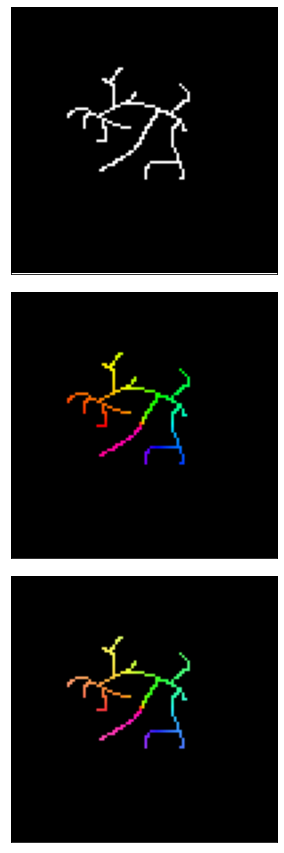

In [ ]:
complex = plt.imread('complex.png')
plt.figure(figsize=(4,12))
plt.subplot(311)
plt.imshow(complex)
plt.xticks([])
plt.yticks([])
plt.subplot(312)
plt.imshow(complex*color)
plt.xticks([])
plt.yticks([])
plt.subplot(313)
plt.imshow(complex*color_grad)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
if save: plt.savefig('scenes/complex')
plt.show()

### 1D Images

In [ ]:
W = 32
focal = 20.0
near = 10.0
far = 50.0
radius = 45.0
N_samples = 45

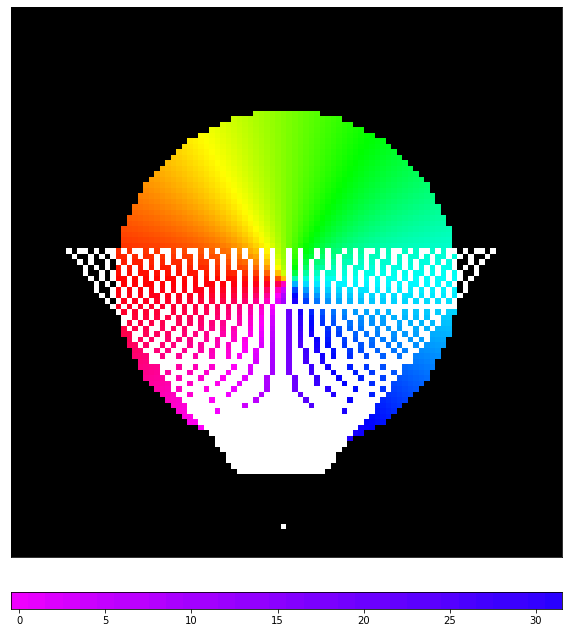

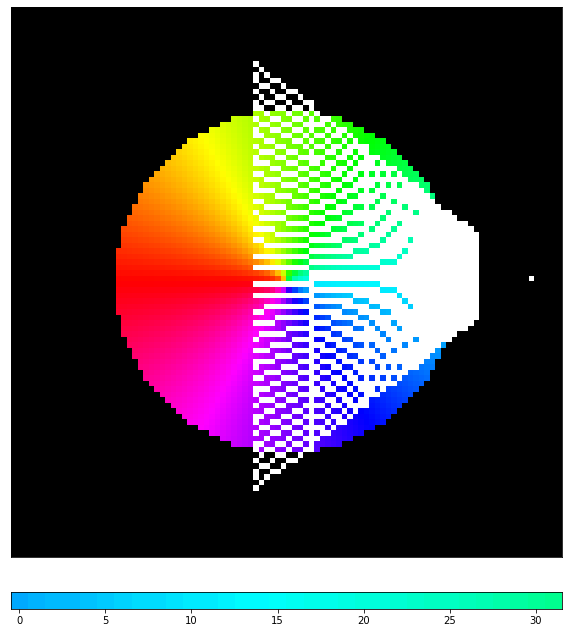

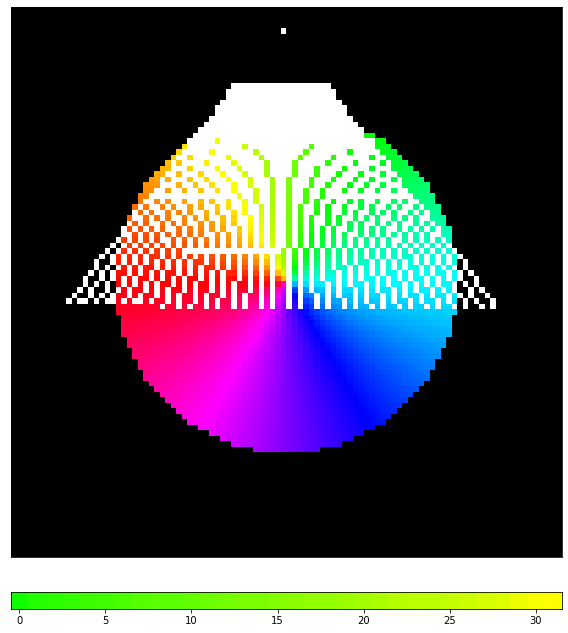

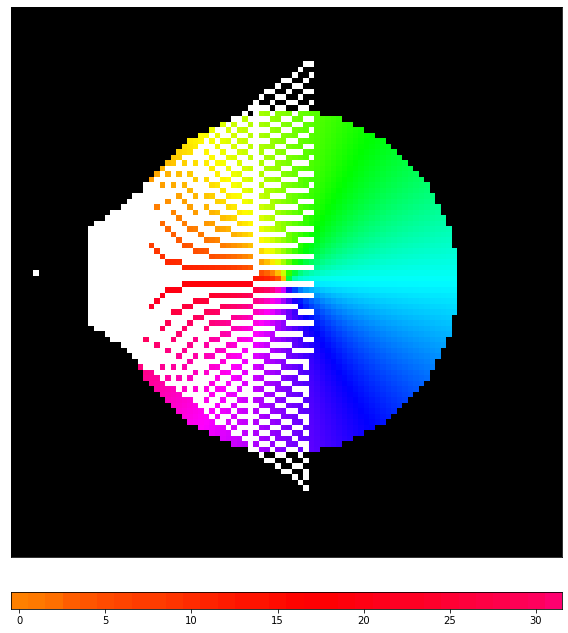

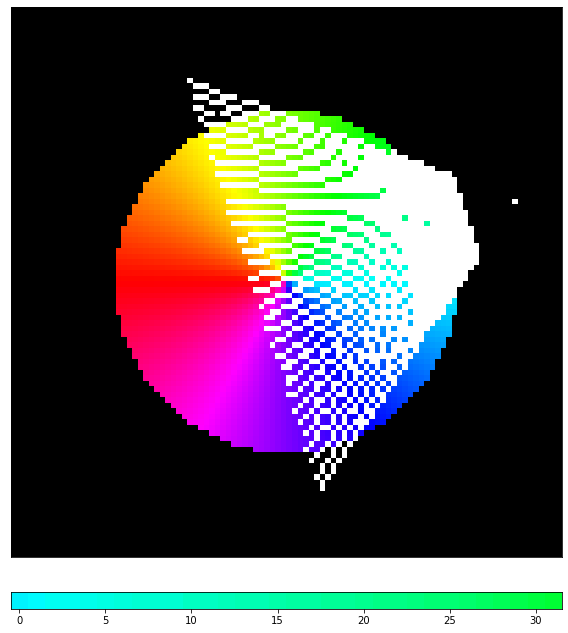

In [ ]:
scene = disk*color
settings = {'bottom':0,'right':90,'top':180,'left':270,'108':108}
for name, theta in settings.items():
    rays_o, rays_d = get_rays(W=W,focal=focal,c2w=pose_spherical(theta=theta,radius=radius))
    image1D = project_rays(scene,rays_o,rays_d,near=near,far=far,N_samples=N_samples,show=True)
    plt.subplot2grid((9,1),(8,0),rowspan=1)
    plt.imshow(image1D)
    plt.yticks([])
    plt.tight_layout()
    if save: plt.savefig(f'disk/{name}')
    plt.show()

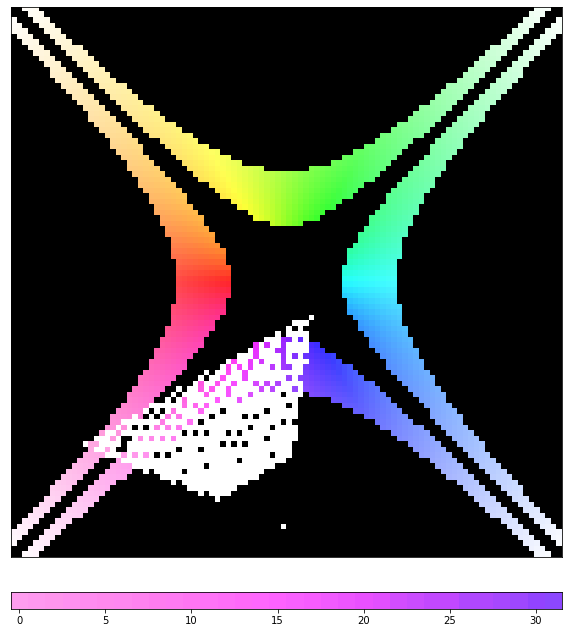

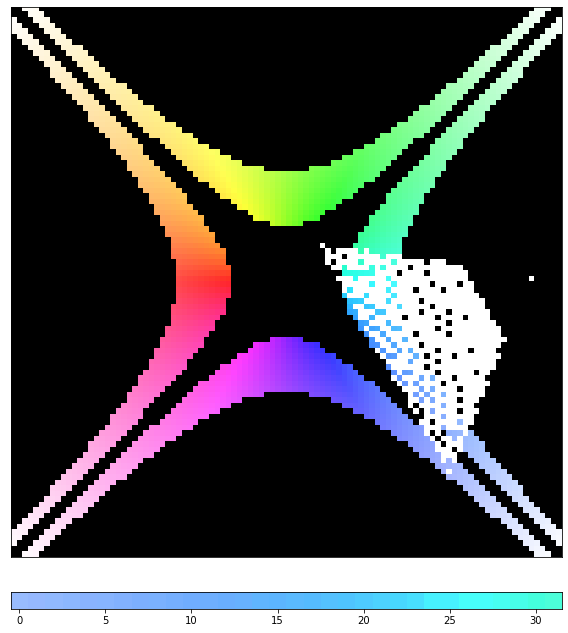

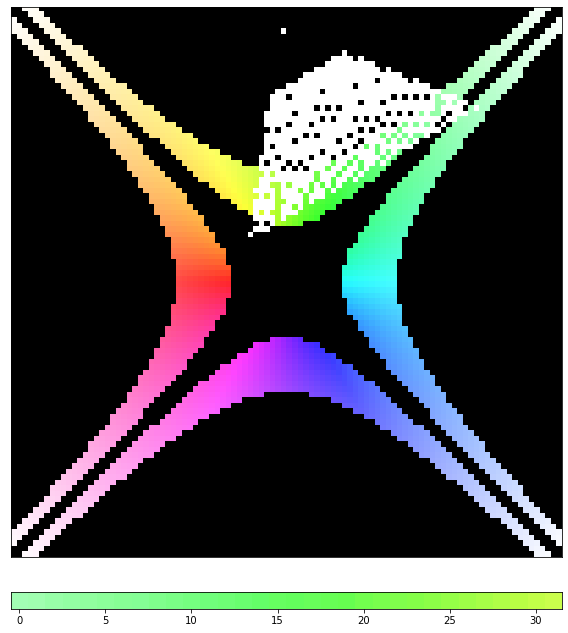

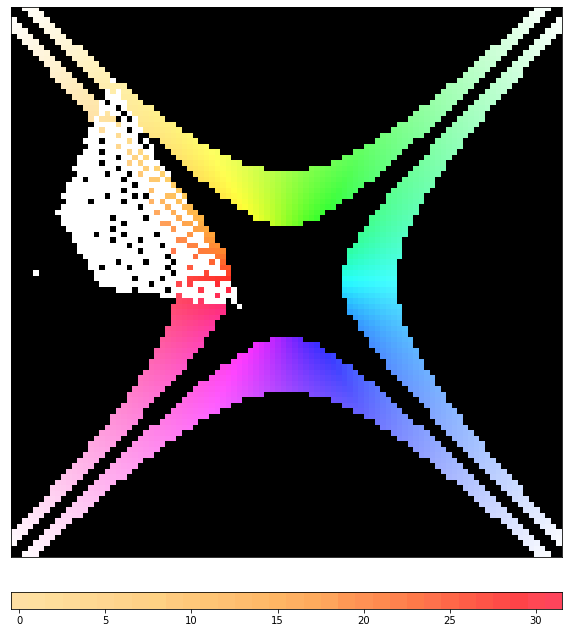

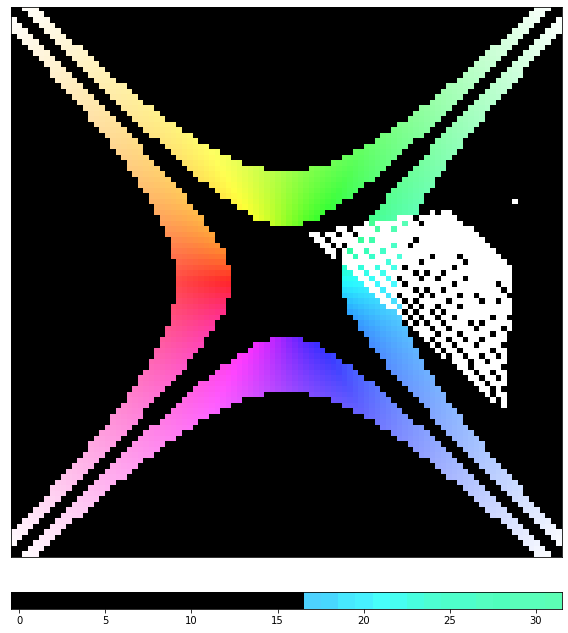

In [ ]:
far = 30.0
N_samples = 20
scene = hyperbolas*color_grad
settings = {'bottom':0,'right':90,'top':180,'left':270,'108':108}
for name, theta in settings.items():
    rays_o, rays_d = get_rays(W=W,focal=focal,c2w=pose_spherical(theta=theta,radius=radius,phi=30))
    image1D = project_rays(scene,rays_o,rays_d,near=near,far=far,N_samples=N_samples,show=True)
    plt.subplot2grid((9,1),(8,0),rowspan=1)
    plt.imshow(image1D)
    plt.yticks([])
    plt.tight_layout()
    if save: plt.savefig(f'hyperbolas/{name}')
    plt.show()

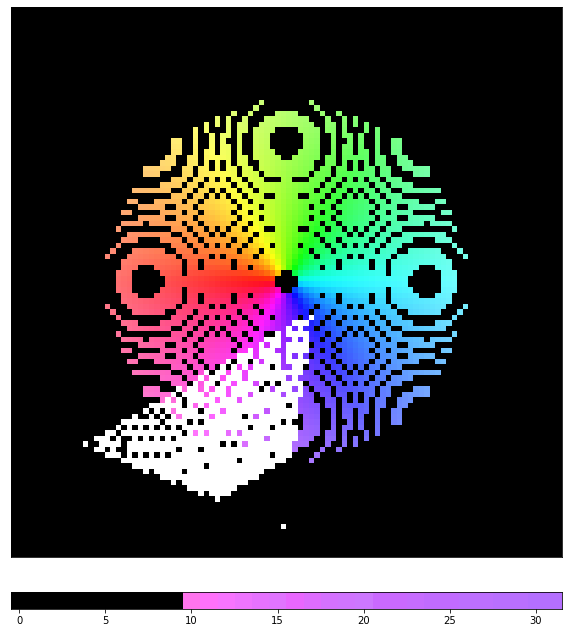

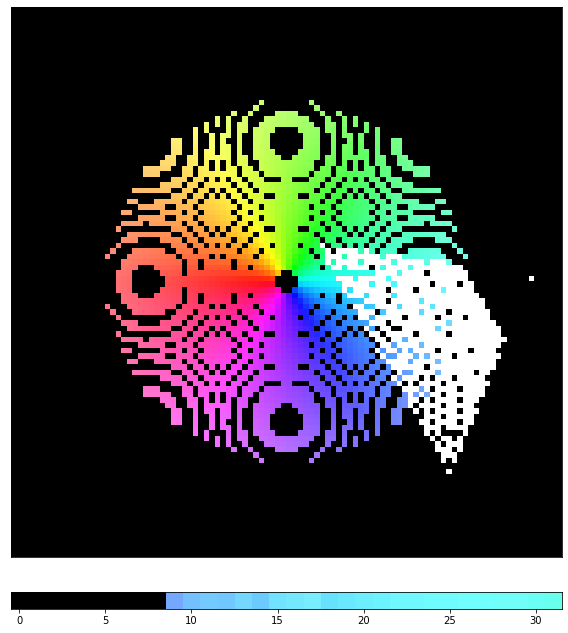

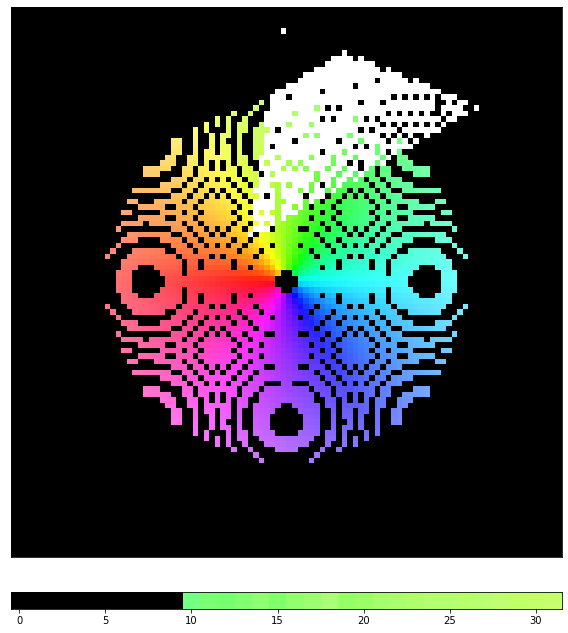

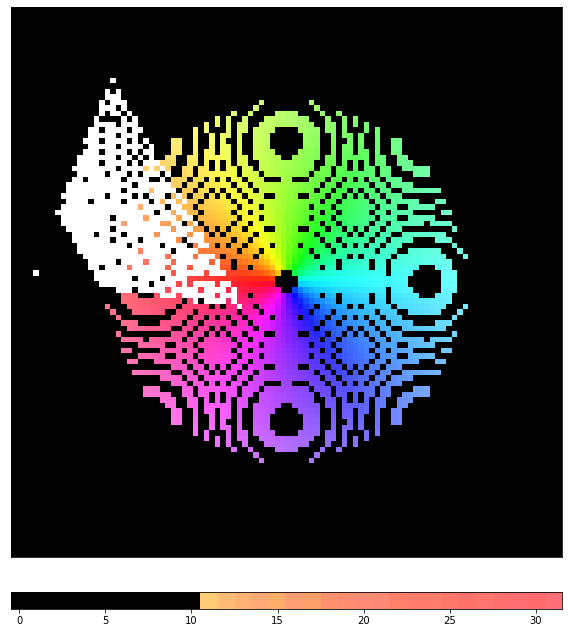

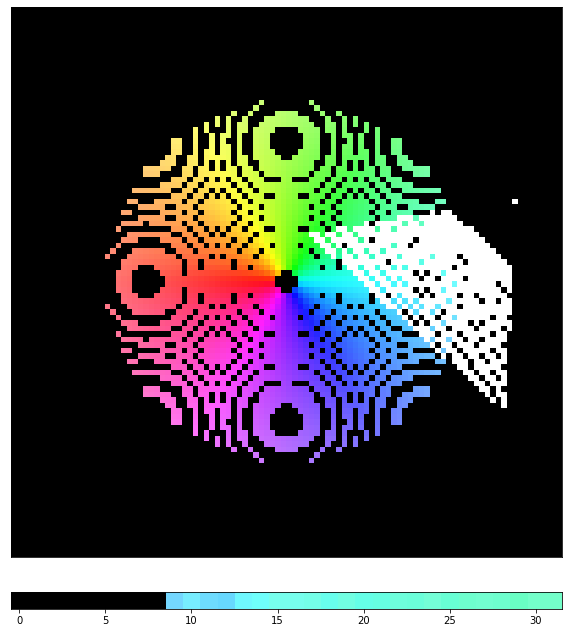

In [ ]:
scene = pattern*color_grad
settings = {'bottom':0,'right':90,'top':180,'left':270,'108':108}
for name, theta in settings.items():
    rays_o, rays_d = get_rays(W=W,focal=focal,c2w=pose_spherical(theta=theta,radius=radius,phi=30))
    image1D = project_rays(scene,rays_o,rays_d,near=near,far=far,N_samples=N_samples,show=True)
    plt.subplot2grid((9,1),(8,0),rowspan=1)
    plt.imshow(image1D)
    plt.yticks([])
    plt.tight_layout()
    if save: plt.savefig(f'patterns/{name}')
    plt.show()

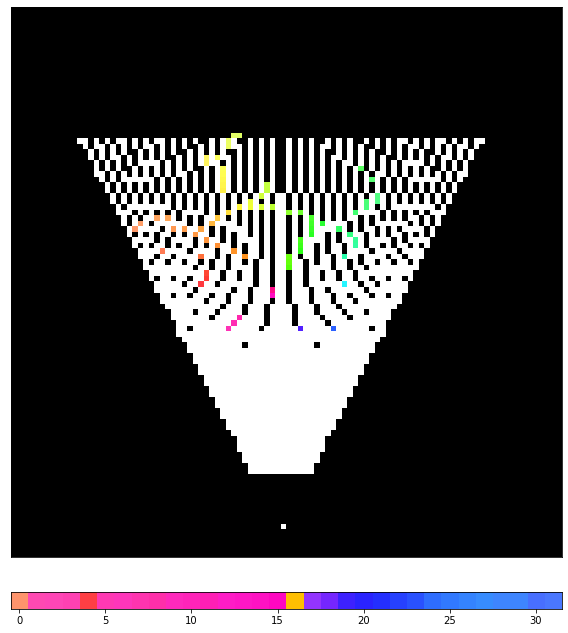

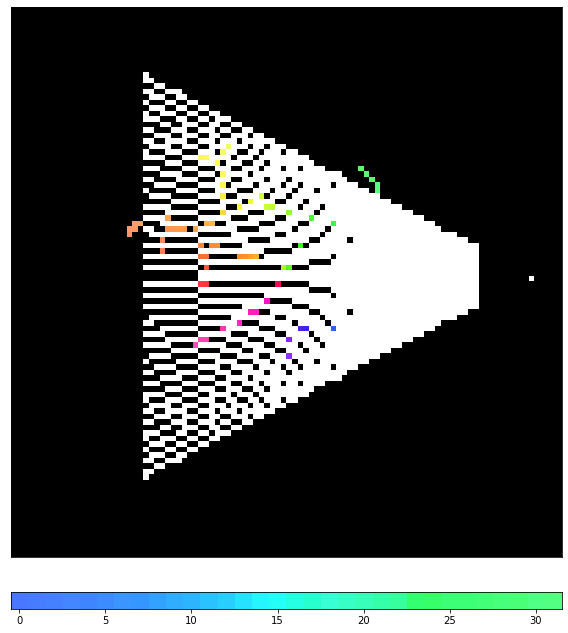

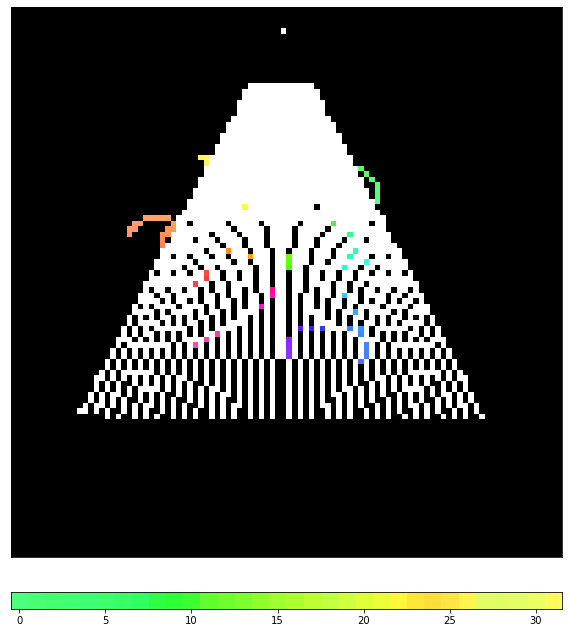

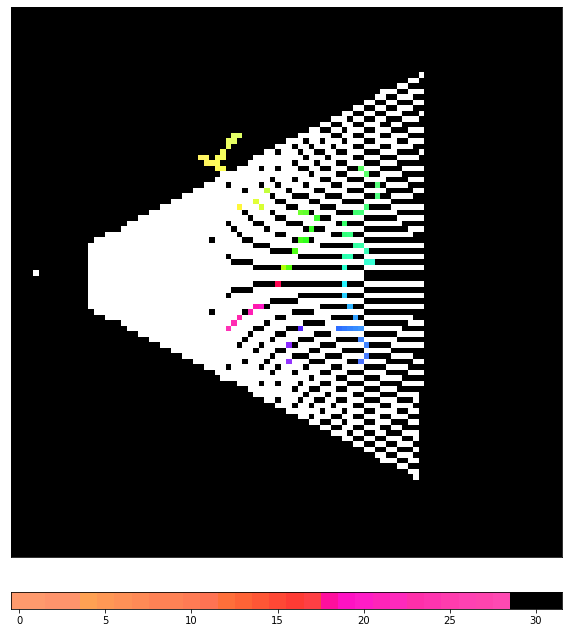

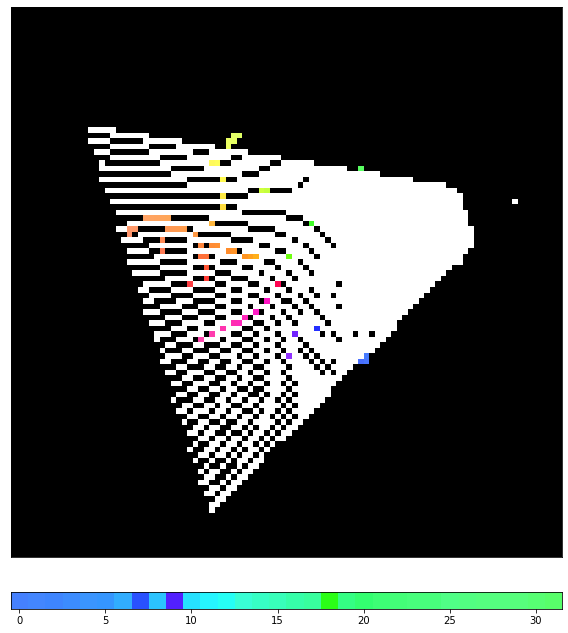

In [ ]:
far = 70.0
focal = 30.0
N_samples = 100
scene = complex*color_grad
settings = {'bottom':0,'right':90,'top':180,'left':270,'108':108}
for name, theta in settings.items():
    rays_o, rays_d = get_rays(W=W,focal=focal,c2w=pose_spherical(theta=theta,radius=radius))
    image1D = project_rays(scene,rays_o,rays_d,near=near,far=far,N_samples=N_samples,show=True)
    plt.subplot2grid((9,1),(8,0),rowspan=1)
    plt.imshow(image1D)
    plt.yticks([])
    plt.tight_layout()
    if save: plt.savefig(f'complex/{name}')
    plt.show()

## Generation

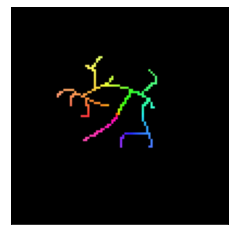

In [ ]:
scene = complex*color_grad
plt.imshow(scene)
plt.yticks([])
plt.xticks([])
plt.show()

In [ ]:
samples = 360
W = 32
focal = 30.0
near = 10.0
far = 70.0
radius = 45.0
N_samples = 100

train_images = []
train_poses = []

data_split = 5

test_images = []
test_poses = []

thetas = np.linspace(0,360,samples,endpoint=False)

In [ ]:
for sample in range(samples):
    theta = thetas[sample]
    pose = pose_spherical(theta=theta,radius=radius)
    rays_o, rays_d = get_rays(W=W,focal=focal,c2w=pose)
    image = project_rays(scene,rays_o,rays_d,near=near,far=far,N_samples=N_samples)
    if sample%data_split==0:
        train_images.append(image.squeeze())
        train_poses.append(pose)
    else:
        test_images.append(image.squeeze())
        test_poses.append(pose)

train_images = np.array(train_images)
train_poses = np.array(train_poses)

test_images = np.array(test_images)
test_poses = np.array(test_poses)

(72, 32, 3) (72, 3, 3)


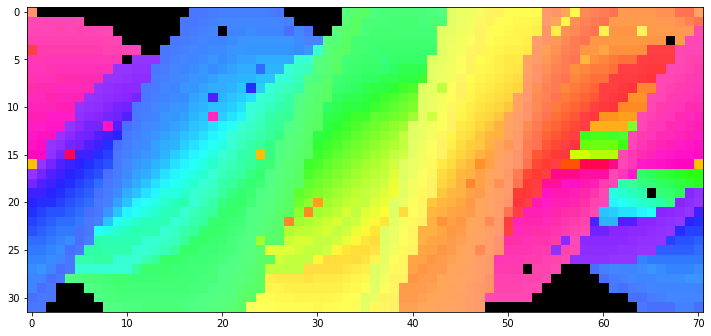

In [ ]:
print(train_images.shape,train_poses.shape)
plt.figure(figsize=(10,5))
plt.imshow(np.transpose(train_images[:-1],axes=(1,0,2)))
# plt.yticks([])
# plt.xticks([])
plt.tight_layout()
if save: plt.savefig('results/train')
plt.show()

(288, 32, 3) (288, 3, 3)


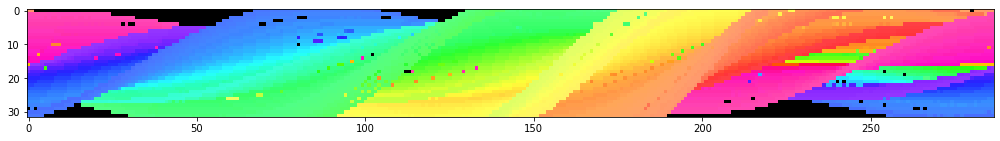

In [ ]:
print(test_images.shape,test_poses.shape)
plt.figure(figsize=(14,2))
plt.imshow(np.transpose(test_images[:-1],axes=(1,0,2)))
# plt.yticks([])
# plt.xticks([])
plt.tight_layout()
if save: plt.savefig('results/test')
plt.show()

# NeRF

## Code

In [ ]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 4
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(2 + 2*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 2D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    # (W, N_samples, 2)
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,2]) # (W*N_samples,2)
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

## Training

In [ ]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

images = train_images
poses = train_poses

steps = 60_000
log_step = int(steps*0.01)
test_loss = []
train_loss = []

In [ ]:
if not pretrained:
    for step in tqdm(range(steps)):
        img_i = np.random.randint(images.shape[0])
        target = images[img_i]
        pose = poses[img_i]
        rays_o, rays_d = get_rays(W,focal,pose)
        with tf.GradientTape() as tape:
            rgb, _, _ = render_rays(model,rays_o,rays_d,near,far,N_samples,rand=True)
            mse = tf.reduce_mean(tf.square(rgb - target))
        gradients = tape.gradient(mse, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if step%log_step==0:
            train_loss.append(mse.numpy().item())
            loss = 0
            for j in range(test_images.shape[0]):
                target = test_images[j]
                pose = test_poses[j]
                rays_o, rays_d = get_rays(W,focal,pose)
                _ = render_rays(model,rays_o,rays_d,near,far,N_samples)
                loss += tf.reduce_mean(tf.square(rgb - target)).numpy().item()
            test_loss.append(loss/test_images.shape[0])

    if save: model.save_weights('model/nerf2d')
else: model.load_weights('model/nerf2d')

## Results

### Metrics

In [ ]:
train_loss = np.array(train_loss).squeeze()
test_loss = np.array(test_loss).squeeze()
if save: np.savez('metrics/losses',train_loss=train_loss,test_loss=test_loss)

train_psnr = -10*np.log10(train_loss)
test_psnr = -10*np.log10(test_loss)

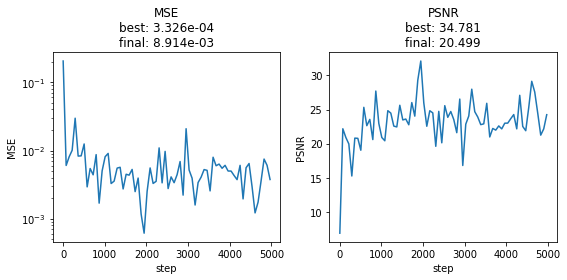

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title(f'MSE\nbest: {train_loss.min():.3e}\nfinal: {train_loss[-1]:.3e}')
plt.semilogy(np.arange(0,steps,log_steps),train_loss)
plt.xlabel('step')
plt.ylabel('MSE')
plt.subplot(122)
plt.title(f'PSNR\nbest: {train_psnr.max():.3f}\nfinal: {train_psnr[-1]:.3f}')
plt.plot(np.arange(0,steps,log_step),train_psnr)
plt.xlabel('step')
plt.ylabel('PSNR')
plt.tight_layout()
if save: plt.savefig('metrics/train')
plt.show()

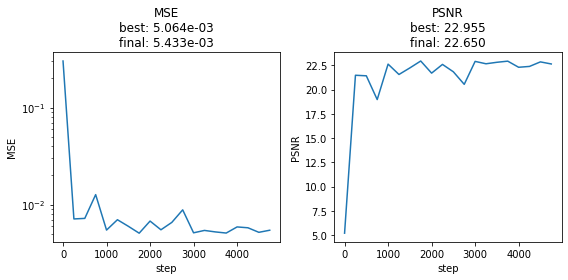

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title(f'MSE\nbest: {test_loss.min():.3e}\nfinal: {test_loss[-1]:.3e}')
plt.semilogy(np.arange(0,steps,log_step),test_loss)
plt.xlabel('step')
plt.ylabel('MSE')
plt.subplot(122)
plt.title(f'PSNR\nbest: {test_psnr.max():.3f}\nfinal: {test_psnr[-1]:.3f}')
plt.plot(np.arange(0,steps,log_step),test_psnr)
plt.xlabel('step')
plt.ylabel('PSNR')
plt.tight_layout()
if save: plt.savefig('metrics/test')
plt.show()

    plt.figure(figsize=(16,10))
    plt.subplot(211)
    plt.title(f'MSE\nbest: {train_loss.min():.3e}\nfinal: {train_loss[-1]:.3e}')
    plt.semilogy(np.arange(steps),train_loss)
    plt.xlabel('step')
    plt.ylabel('MSE')
    plt.subplot(212)
    plt.title(f'PSNR\nbest: {train_psnr.max():.3f}\nfinal: {train_psnr[-1]:.3f}')
    plt.plot(np.arange(steps),train_psnr)
    plt.xlabel('step')
    plt.ylabel('PSNR')
    plt.tight_layout()
    if save: plt.savefig('metrics/train_full')
    plt.show()

### Visualization

In [ ]:
actual_scene = []
model_scene = []
thetas = np.linspace(0,360,samples,endpoint=False)

for theta in thetas:
    pose = pose_spherical(theta,radius)
    rays_o, rays_d = get_rays(W,focal,pose)
    image = project_rays(scene,rays_o,rays_d,near,far,N_samples)
    actual_scene.append(image)
    image, _, _ = render_rays(model,rays_o,rays_d,near,far,N_samples)
    model_scene.append(image)

actual_scene = np.array(actual_scene).squeeze()
model_scene = np.array(model_scene)

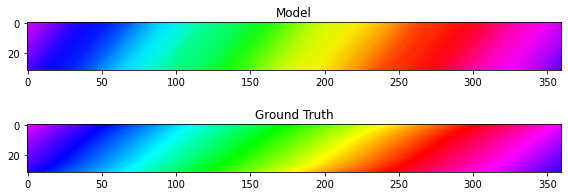

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(211)
plt.title('Model')
plt.imshow(np.transpose(model_scene,axes=(1,0,2)))
# plt.yticks([])
# plt.xticks([])
plt.subplot(212)
plt.title('Ground Truth')
plt.imshow(np.transpose(actual_scene,axes=(1,0,2)))
# plt.yticks([])
# plt.xticks([])
plt.tight_layout()
if save: plt.savefig('results/qualitative')
plt.show()

In [ ]:
frames = []
for i in range(360):
    frame = np.stack([model_scene[i],actual_scene[i]])
    frame = np.clip(frame,0,1)
    frame = np.repeat(frame,16,axis=1)
    frame = np.repeat(frame,16,axis=0)
    frame = (255*frame).astype(np.uint8)
    frames.append(frame)

import imageio
f = 'results/comparison.gif'
if save: imageio.mimwrite(f, frames, fps=30)

In [ ]:
if save:
    ! zip -r TinyNeRF2D metrics model results

# Interactive Visualization

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets

def f(**kwargs):
    pose = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(W,focal,pose)
    rgb, depth, acc = render_rays(model,rays_o,rays_d,near,far,N_samples)
    rgb = np.expand_dims(np.clip(rgb,0,1),0)
    depth = np.expand_dims(depth,0)
    
    plt.figure(2, figsize=(20,3))
    plt.subplot(211)
    plt.imshow(rgb)
    plt.subplot(212)
    plt.imshow(depth)
    plt.tight_layout()
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [0., 0., 360]],
    ['radius', [radius, 1., 100.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='theta', max=360.0, step=0.01), FloatSlider(value=45.…